In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.layers import Dense, Lambda, Flatten, Conv2D, Concatenate, Input
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

In [91]:
INPUT_WIDTH = INPUT_HEIGHT =  250
ALPHA = 0.2

In [92]:
def get_model():
    vgg = vgg19.VGG19(weights = 'imagenet', include_top=False, input_shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))
    vgg.trainable = False
    
    model = Sequential()
    model.add(vgg)
    model.add(Conv2D(kernel_size=3, filters=1024, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    
    return model

In [4]:
# vgg = vgg19.VGG19(include_top=False)
# vgg.trainable = False

In [5]:
# for layers in vgg.layers:
#     print(layers.name)

In [6]:
# vgg.summary()

In [93]:
def triplet_loss(y_true, y_pred, alpha=ALPHA):
    shape = y_pred.shape[1] // 3
    A = y_pred[:,0:shape]
    P = y_pred[:,shape:shape*2]
    N = y_pred[:,shape*2:shape*3]
    loss = K.max(K.square(A-P) - K.square(A-N) + alpha, 0)
    return loss

In [94]:
vgg_model = get_model()

In [95]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 1024)        4719616   
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              26215424  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
Total params: 51,549,888
Trainable params: 31,525,504
Non-trainable params: 20,024,384
___________________________________

In [96]:
def get_final_model():
    vgg_model = get_model()
    input_1 = Input(shape = (INPUT_HEIGHT, INPUT_WIDTH, 3))
    input_2 = Input(shape= (INPUT_HEIGHT, INPUT_WIDTH, 3))
    input_3 = Input(shape = (INPUT_HEIGHT, INPUT_WIDTH,3))
    
    A = vgg_model(input_1)
    P = vgg_model(input_2)
    N = vgg_model(input_3)
    inputs = [input_1, input_2, input_3]
    output = Concatenate(name='final_concatenate_layer')([A,P,N])
    model = tf.keras.models.Model(inputs=inputs, outputs = output)
    return model

In [97]:
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(INPUT_HEIGHT, INPUT_WIDTH))
    img = img_to_array(img)
#     img = img[np.newaxis,...]
    img = img / 255.0
    return img

In [98]:
def preprocess_for_vgg(img):
    img = img * 255.0
    img = vgg19.preprocess_input(img)

In [99]:
negative_path = "data\Aaron_Guiel\Aaron_Guiel_0001.jpg"
positive_path = "data\Aaron_Peirsol\Aaron_Peirsol_0002.jpg"
anchor_path = "data\Aaron_Peirsol\Aaron_Peirsol_0001.jpg"

In [100]:
anchor_image = preprocess_image(anchor_path)
negative_image = preprocess_image(negative_path)
positive_image = preprocess_image(positive_path)

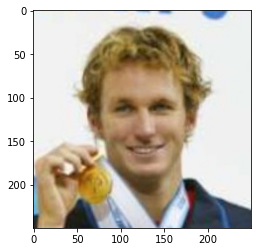

In [101]:
plt.imshow(anchor_image)

In [16]:
# model(preprocess_for_vgg(positive_image))

In [17]:
# tf.reduce_sum(triplet_loss(A,P,N)).numpy()

In [18]:
# with tf.GradientTape() as tape:
#     A = model(preprocess_for_vgg(anchor_image))
#     P = model(preprocess_for_vgg(positive_image))
#     N = model(preprocess_for_vgg(negative_image))
#     loss = triplet_loss(A,P,N)
#     grad = tape.gradient(loss, image)
#     opt.apply_gradients([(grad, image)])
#     image.assign(self.clip_0_1(image))
#     return loss

In [19]:
# import os
# for dirpath, dirname, files in os.walk('data/data/lfw-funneled/lfw_funneled/'):
#     print(dirpath)

In [20]:
# import os
# import shutil

# for dirpath, dirname, files in os.walk('data/'):
#     if len(files) == 2:
        

In [13]:
with open('data/pairs_01.txt', 'r') as f:
    ls = f.readlines()

In [14]:
ls = [l.strip() for l in ls]

In [15]:
anchor = []
positive = []
negative = []

In [16]:
for idx, data in enumerate(ls):
    if idx % 5 == 0:
        anchor.append(data)
        positive.append(ls[idx+1])
        negative.append(ls[idx+2])

In [17]:
path = 'data/'+str(anchor[0])
img = preprocess_image(path)

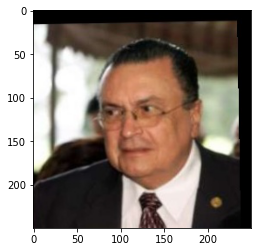

In [18]:
plt.imshow(img)

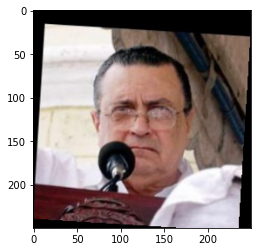

In [19]:
path = 'data/'+str(positive[0])
img = preprocess_image(path)
plt.imshow(img)

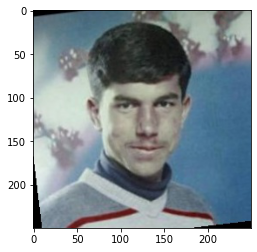

In [20]:
path = 'data/'+str(negative[0])
img = preprocess_image(path)
plt.imshow(img)

In [21]:
stacked = np.stack([anchor_image, negative_image], axis=0)

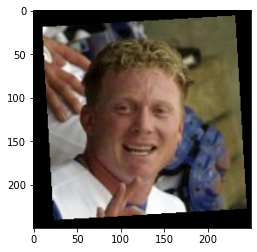

In [22]:
plt.imshow(stacked[1])

In [23]:
stacked.shape

(2, 250, 250, 3)

In [102]:
def create_dataset(img_paths):
    final_data = []
    for idx in range(len(img_paths)):
        path = 'data/'+str(img_paths[idx])
        img = preprocess_image(path)
        final_data.append(img)

    return np.stack(final_data, axis=0)

In [25]:
anchor_dataset = create_dataset(anchor)
positive_dataset = create_dataset(positive)
negative_dataset = create_dataset(negative)

In [26]:
anchor_dataset.shape

(300, 250, 250, 3)

In [27]:
positive_dataset.shape

(300, 250, 250, 3)

In [28]:
negative_dataset.shape

(300, 250, 250, 3)

In [103]:
model = get_final_model()

In [104]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          51549888    input_3[0][0]                    
                                                                 input_4[0][0]                

In [39]:
# path = 'data/'+str(anchor[0])
# img1 = preprocess_image(path)
# path = 'data/'+str(positive[0])
# img2 = preprocess_image(path)
# path = 'data/'+str(negative[0])
# img3 = preprocess_image(path)
# # model(preprocess_image(img[np.newaxis,...]))

In [40]:
# img.shape

In [41]:
# img1 = img1[np.newaxis, ...]
# img2 = img2[np.newaxis, ...]
# img3 = img3[np.newaxis, ...]

In [42]:
# img.shape

In [43]:
# op = model([img1,img2,img3])

In [44]:
# op[:,256:]

In [105]:
model.compile(loss=triplet_loss,
             optimizer = 'sgd',
             metrics=['accuracy'])

In [32]:
y = np.ones((300,1))

In [106]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('Model_Checkpoints/',
                                                         save_best_only=True,
                                                        monitor='loss'
                                                        )

In [34]:
model.fit([anchor_dataset, positive_dataset, negative_dataset],y,epochs=3, batch_size=10, verbose=1)

Epoch 1/3
30/30 [==============================] - 112s 2s/step - loss: 0.2217 - accuracy: 0.0000e+00
Epoch 2/3
30/30 [==============================] - 61s 2s/step - loss: 0.2080 - accuracy: 0.0000e+00
Epoch 3/3
30/30 [==============================] - 61s 2s/step - loss: 0.2055 - accuracy: 0.0000e+00


In [35]:
model.save('Model.h5')

In [107]:
def get_inference_model():
#     vgg_model = get_model()
    model = tf.keras.models.load_model('Model.h5', compile=False)
    model = model.layers[3]
    
    input_1 = Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))
    input_2 = Input(shape=(INPUT_HEIGHT, INPUT_WIDTH, 3))
    
    encoded_1 = model(input_1)
    encoded_2 = model(input_2)
    
    model = tf.keras.models.Model(inputs=[input_1, input_2], outputs=[encoded_1, encoded_2])
     
    return model

In [40]:
model = model

In [44]:
model = model.layers[3]

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 1024)        4719616   
_________________________________________________________________
flatten_1 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              26215424  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
Total params: 51,549,888
Trainable params: 31,525,504
Non-trainable params: 20,024,384
_________________________________

In [50]:
inference_model = get_inference_model()

In [51]:
inference_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          51549888    input_6[0][0]                    
                                                                 input_7[0][0]                    
Total params: 51,549,888
Trainable params: 31,525,504
Non-trainable params: 20,024,384
__________________________________________________________________________________________________


In [204]:
def predict(inputs):
    img1, img2 = inputs
    img1 = preprocess_image(img1)
    img2 = preprocess_image(img2)
    img1 = img1[np.newaxis,...]
    img2 = img2[np.newaxis,...]
    output1, output2 = inference_model([img1,img2])
    score = K.sum(K.abs(output1 - output2))
    similarity_score = tf.nn.sigmoid(score)
    
    if similarity_score >= 0.5:
        print("SAME")
    else:
        print("DIFFERENT")
    print(similarity_score)

In [70]:
path1 = 'data/Abdullah/Abdullah_0001.jpg'
path2 = 'data/Abdullah_Gul/Abdullah_Gul_0001.jpg'

In [71]:
img1 = preprocess_image(path1)

In [72]:
img2 = preprocess_image(path2)

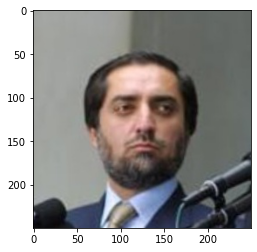

In [73]:
plt.imshow(img1)

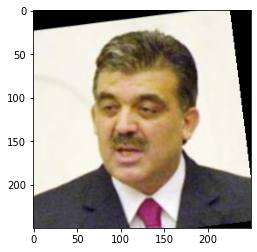

In [74]:
plt.imshow(img2)

In [75]:
img1 = img1[np.newaxis,...]
img2 = img2[np.newaxis,...]

In [76]:
output1, output2 = inference_model([img1,img2])
score = K.sum(K.abs(output1 - output2))
similarity_score = tf.nn.sigmoid(score)

In [77]:
similarity_score

<tf.Tensor: shape=(), dtype=float32, numpy=0.9423003>

In [15]:
import os
import shutil
PATH = "data/more_pairs/"
dirs = []
for dirpath, dirname, files in os.walk(PATH):
    if len(files) > 10:
        dirs.append(dirpath)
print(len(dirs))
dirs = dirs[1:]

143


In [17]:
dirs[:5]

['data/more_pairs/Adrien_Brody',
 'data/more_pairs/Alejandro_Toledo',
 'data/more_pairs/Alvaro_Uribe',
 'data/more_pairs/Amelie_Mauresmo',
 'data/more_pairs/Andre_Agassi']

In [135]:
single_img_dirs = []
for dirpath, dirname, files in os.walk('data/'):
    if len(files)==1:
        single_img_dirs.append(dirpath)

In [136]:
len(single_img_dirs)

4069

In [40]:
import random

In [42]:
move_dirs = random.sample(single_img_dirs,143)

In [45]:
for mv_dir in move_dirs:
    shutil.move(mv_dir,'data/more_pairs/')

In [47]:
one = []
more = []
for dirpath, dirname, files in os.walk('data/more_pairs'):
    if len(files) == 1:
        one.append(dirpath)
        
    if len(files) > 10:
        more.append(dirpath)
        
        
print(len(one))
print(len(more))

143
143


In [172]:
anchor = []
positive = []
for PATH in dirs:
    for root, dirpath, files in os.walk(PATH):
        for idx,file in enumerate(files):
            if idx == 0:
                anchor.append(f"{PATH}/{file}")
            elif idx > 10:
                break
            else:
                positive.append(f"{PATH}/{file}")

In [173]:
negative = []
for PATH in single_img_dirs:
    for root, dirpath, files in os.walk(PATH):
        negative.append(f"{PATH}/{files[0]}")

['Aaron_Eckhart_0001.jpg']

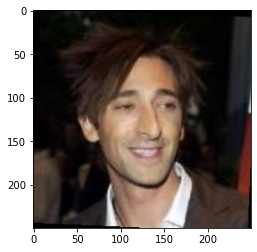

In [174]:
path = anchor[0]
plt.imshow(preprocess_image(path))

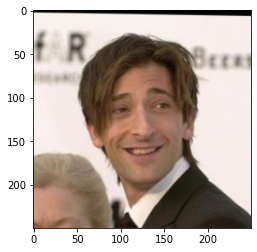

In [175]:
path = positive[9]
plt.imshow(preprocess_image(path))

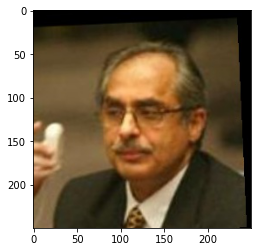

In [176]:
neg = random.sample(negative,1)
path = neg[0]
plt.imshow(preprocess_image(path))

In [177]:
# len(negative)
anco =[]

In [178]:
for anc in anchor:
    for j in range(10):
        anco.append(anc)

In [179]:
len(anco)

1420

In [180]:
len(positive)

1420

In [181]:
anchor = anco

In [182]:
negative = random.sample(negative,1420)

In [184]:
len(negative)

1420

In [185]:
def create_dataset(img_paths):
    final_data = []
    for idx in range(len(img_paths)):
        path = img_paths[idx]
        img = preprocess_image(path)
        final_data.append(img)

    return np.stack(final_data, axis=0)

In [189]:
anchor_dataset = create_dataset(anchor)
positive_dataset = create_dataset(positive)
negative_dataset = create_dataset(negative)

In [190]:
print("Anchor: ",anchor_dataset.shape)
print("Positive: ",positive_dataset.shape)
print("Negative: ",negative_dataset.shape)

Anchor:  (1420, 250, 250, 3)
Positive:  (1420, 250, 250, 3)
Negative:  (1420, 250, 250, 3)


In [192]:
y = np.ones((1420,1))
# y

In [193]:
model.fit([anchor_dataset, positive_dataset, negative_dataset],y,epochs=10, batch_size=10, verbose=1)

Epoch 1/3
142/142 [==============================] - 401s 2s/step - loss: 0.2123 - accuracy: 0.0000e+00
Epoch 2/3
142/142 [==============================] - 556s 4s/step - loss: 0.2029 - accuracy: 0.0000e+00
Epoch 3/3
142/142 [==============================] - 510s 4s/step - loss: 0.2021 - accuracy: 0.0000e+00


In [194]:
model.save('Model.h5')

In [1]:
inference_model = get_inference_model()

NameError: name 'get_inference_model' is not defined

In [196]:
inference_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          51549888    input_6[0][0]                    
                                                                 input_7[0][0]                    
Total params: 51,549,888
Trainable params: 31,525,504
Non-trainable params: 20,024,384
__________________________________________________________________________________________________


In [208]:
path1 = 'data/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg'
path2 = 'data/Abdoulaye_Wade/Abdoulaye_Wade_0001.jpg'

In [209]:
predict([path1,path2])

SAME
tf.Tensor(0.5, shape=(), dtype=float32)
